In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eqmarl import *
import gymnasium as gym
from functools import reduce
import tensorflow_quantum as tfq
import tensorflow as tf
import tensorflow.keras as keras
import cirq

2023-11-06 10:48:13.442693: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# env_name = "FrozenLake-v1"
env_name = "CartPole-v1"
# env_name = "MountainCar-v0"
env = gym.make(env_name)
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

In [4]:
# Actor Critic in TensorFlow.
# https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

In [52]:
def interact_env(
    env: gym.Env,
    actor: keras.Model,
    critic: keras.Model,
    state: Any,
    action_selection_fn: Callable[[tf.Tensor], int],
    ) -> dict[str, Any]:
    
    # Convert state to batched tensor (batch size = 1).
    state = tf.expand_dims(state, 0)

    # Get action probabilities at current state.
    probs = actor(state)

    # Select action.
    # action = int(action_selection_fn(probs).numpy()[0])
    action = action_selection_fn(probs)

    # Get value from critic at current state.
    value = critic(state)

    # Apply action in the environment, receive reward and next state.
    next_state, reward, done, _, _ = env.step(action)

    # Build dictionary denoting interaction.
    interaction = {
        'state': state,
        'action': action,
        'action_probs': probs,
        'value': value,
        'reward': reward,
        'done': done,
        'next_state': next_state.copy(),
    }
    return interaction


def run_episode(
    env: gym.Env,
    max_steps: int,
    actor: keras.Model,
    critic: keras.Model,
    action_selection_fn: Callable[[tf.Tensor], int] = lambda probs: int(tf.argmax(probs, axis=1).numpy()[0]), # Greedy, always take action with highest probability.
    ):
    
    history: list[dict] = [] # dict(state, action, reward, next_state)
    
    state, _ = env.reset()
    for t in tf.range(max_steps):

        interaction = interact_env(
            env=env,
            actor=actor,
            critic=critic,
            state=state,
            action_selection_fn=action_selection_fn,
        )
        history.append(interaction)
        
        # Terminate episode if environment terminates.
        if tf.cast(interaction['done'], tf.bool):
            print(f"DONE: {t=}")
            break
        
    return history

In [11]:
env_name = "CartPole-v1"
env = gym.make(env_name)
env.observation_space, env.action_space

n_qubits = 4 # Dimension of observation space in environment.
n_actions = 2 # Number of actions in environment.

n_layers = 1
beta = 1.0 # Inverse temperature parameter for softmax policy.

qubits = cirq.LineQubit.range(n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x*y), ops)]

actor = QuantumActorVariationalEncoding(
    qubits=qubits,
    n_actions=n_actions,
    n_layers=n_layers,
    beta=beta,
    name='actor',
)
actor.summary()

critic = ClassicalCriticDense(units=[5, 10, 15], name='critic')
critic.build((None, *env.observation_space.shape))
critic.summary()

# model.build(input_shape=(None, n_qubits,))

# input_tensor = tf.keras.Input(shape=(n_qubits,), dtype='float32', name='input')
# x = input_tensor
# x = VariationalEncodingPQC(observables, qubits, n_layers, name='pqc')([x])
# # observables
# x = WeightedAlternatingSoftmaxPolicy(beta=beta, n_actions=n_actions, name='policy')(x)
# model = tf.keras.Model(inputs=[input_tensor], outputs=x)
# # pqc([input_tensor])
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

Model: "actor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 pqc (VariationalEncodingPQC  (None, 1)                28        
 )                                                               
                                                                 
 policy (WeightedAlternating  (None, 2)                2         
 SoftmaxPolicy)                                                  
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)           

In [50]:
t = tf.convert_to_tensor([[0.4815702 , 0.51842976], [0.51842976, 0.4815702]])
tf.argmax(t, 1)
np.random.choice(2, p=t[0].numpy())

1

In [68]:
history = run_episode(
    env=env,
    max_steps=100,
    actor=actor,
    critic=critic,
    action_selection_fn=lambda probs: np.random.choice(n_actions, p=t[0].numpy())
)
len(history)

DONE: t=<tf.Tensor: shape=(), dtype=int32, numpy=33>


34

In [55]:
pd.DataFrame(history)

,state,action,action_probs,value,reward,done,next_state
0,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",1,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.043123055, 0.1522679, -0.027747763, -0.253..."
1,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",0,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.040077697, -0.042447075, -0.032813948, 0.0..."
2,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",0,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.04092664, -0.23708346, -0.032204065, 0.312..."
3,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",0,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.045668308, -0.43173218, -0.025951145, 0.59..."
4,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",1,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.054302953, -0.23625682, -0.01405112, 0.294..."
5,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",1,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.05902809, -0.040937386, -0.0081659565, -0...."
6,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",1,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.059846837, 0.15430072, -0.008222416, -0.29..."
7,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",1,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.05676082, 0.3495389, -0.014183838, -0.5933..."
8,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",1,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.049770042, 0.5448565, -0.026050555, -0.890..."
9,"((tf.Tensor(-0.04225798, shape=(), dtype=float...",1,"((tf.Tensor(0.47797477, shape=(), dtype=float3...","((tf.Tensor(0.0038186135, shape=(), dtype=floa...",1.0,False,"[-0.038872913, 0.74032205, -0.04385961, -1.191..."


In [69]:
from PIL import Image
from pathlib import Path

def save_frames_as_gif(frames: list[Image.Image], path: Path, **kwargs):
    frames[1].save(
        path,
        save_all=True,
        append_images=frames[2:],
        optimize=False,
        duration=40,
        loop=0,
        **kwargs,
    )


def render_interactions_as_frames(
    env_name: str,
    interactions: list[dict[str, Any]],
    ) -> list[Image.Image]:
    env = gym.make(env_name, render_mode='rgb_array')
    state = env.reset()
    frames = []
    for interaction in interactions:
        im = Image.fromarray(env.render())
        frames.append(im)
        state, _, done, _, _ = env.step(interaction['action'])
        if done: 
            break
    env.close()
    return frames

In [61]:
import IPython.display
def display_gif(path: Path) -> IPython.display.DisplayHandle:
    return display(
        IPython.display.Image(
            data=open(path,'rb').read(), format='png'),
        )

In [70]:
gif_path = './images/gym_CartPole.gif'
frames = render_interactions_as_frames(env_name, history)
save_frames_as_gif(frames, path=gif_path)

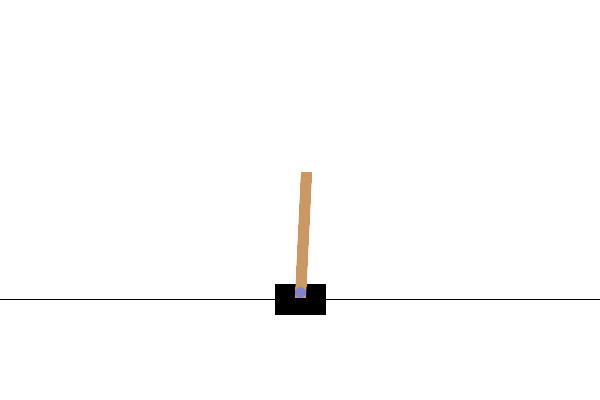

In [71]:
display_gif(gif_path)

In [54]:
actor.layers[1].circuit

0: ───Rx(theta0)───Ry(theta1)────Rz(theta2)────@───Rx(x0_0)───Rx(theta12)───Ry(theta13)───Rz(theta14)───────────────────────────────
                                               │
1: ───Rx(theta3)───Ry(theta4)────Rz(theta5)────X───@──────────Rx(x0_1)──────Rx(theta15)───Ry(theta16)───Rz(theta17)─────────────────
                                                   │
2: ───Rx(theta6)───Ry(theta7)────Rz(theta8)────────X──────────@─────────────Rx(x0_2)──────Rx(theta18)───Ry(theta19)───Rz(theta20)───
                                                              │
3: ───Rx(theta9)───Ry(theta10)───Rz(theta11)──────────────────X─────────────Rx(x0_3)──────Rx(theta21)───Ry(theta22)───Rz(theta23)───

In [55]:
tmp = tfq.convert_to_tensor([cirq.Circuit(), cirq.Circuit()])
tf.repeat(tmp, repeats=1)

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01',
       b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01'], dtype=object)>

In [65]:
state, _ = env.reset()

# Convert state to batched tensor (batch size = 1).
state = tf.expand_dims(state, 0)

# Get action probabilities.
actor.layers[1].theta.shape, actor.layers[1].lmbd.shape
probs = actor([state])
# probs
# state
# actor.layers[1].circuit
# actor.layers[1].pqc.input_spec
probs

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4158523, 0.5841477]], dtype=float32)>

---

In [40]:
sim = cirq.Simulator()

qubits = cirq.LineQubit.range(2)
obs = reduce(lambda a, b: a * b, [cirq.Z(q) for q in qubits]) # Z0 * Z1 * ...
# obs = obs + [cirq.Z(q) for q in qubits] # Z0, Z1, ...
print(type(qubits[0]))
circuit = cirq.Circuit(
    [cirq.H(q) for q in qubits],
    # obs,
    cirq.measure_single_paulistring(obs, key='m'),
    # cirq.measure(*qubits, key='m'),
)
print(f"dirac notation: {sim.simulate(circuit).dirac_notation()}")
print(f"measurements: {sim.run(circuit, repetitions=100).histogram(key='m')}")
# print(f"measurements: {sim.run(circuit, repetitions=100).histogram(key='m0')}")
# print(f"measurements: {sim.run(circuit, repetitions=100).histogram(key='m1')}")
# print(f"measurements: {sim.run(circuit, repetitions=100).histogram(key='m2')}")
print(circuit)

<class 'cirq.devices.line_qubit.LineQubit'>
dirac notation: 0.71|01⟩ + 0.71|10⟩
measurements: Counter({0: 51, 1: 49})
0: ───H───M(Z)('m')───
          │
1: ───H───M(Z)────────


In [77]:
qubits = cirq.LineQubit.range(2)
obs = reduce(lambda a, b: a * b, [cirq.Z(q) for q in qubits]) # Z0 * Z1 * ...
# obs = [cirq.Z(q) for q in qubits] # Z0, Z1, ...
circuit = cirq.Circuit(
    # [cirq.H(q) for q in qubits],
    [cirq.rx(sympy.Symbol(f'theta{i}'))(q) for i, q in enumerate(qubits)]
)
# tfq.convert_to_tensor([circuit])
# circuit

# # l = tfq.layers.AddCircuit(circuit)
# l = tfq.layers.PQC(circuit, obs)
l = tfq.layers.Sample()
quantum_data = tfq.convert_to_tensor([
    cirq.Circuit(),
    # cirq.Circuit([cirq.X(q) for q in qubits]),
])
# print(quantum_data.shape)
# quantum_data = tf.zeros(shape=(2,))
# quantum_data = keras.layers.Input(shape=(1,))
# policy = WeightedAlternatingSoftmaxPolicy(beta=1., n_actions=2)
# policy = AlternatingObservables(n_actions=4)

# x = l(quantum_data)
x = l(circuit, symbol_names=)
print(x)
# x = policy(x)
# print(x)

tf.Tensor([[-0.789022]], shape=(1, 1), dtype=float32)


In [3]:
env_name = "CartPole-v1"
env = gym.make(env_name)
env.reset()

(array([-0.00238119, -0.02606253, -0.02181742,  0.03740089], dtype=float32),
 {})

In [4]:
env_name = "FrozenLake-v1"
env = gym.make(env_name)
env.reset()

(0, {'prob': 1})

In [5]:
tf.Variable(
        initial_value=tf.constant([[(-1.)**i for i in range(4)]]),
        dtype='float32',
        trainable=True,
        name='observables-weights',
    )

<tf.Variable 'observables-weights:0' shape=(1, 4) dtype=float32, numpy=array([[ 1., -1.,  1., -1.]], dtype=float32)>

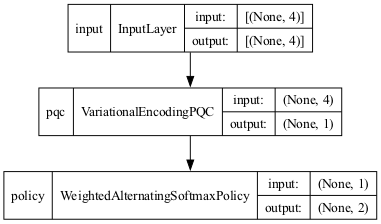

In [9]:
n_qubits = 4
n_layers = 5
n_actions = 2
beta = 1.0 # Inverse temperature parameter for softmax policy.
qubits = cirq.LineQubit.range(n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x*y), ops)]

input_tensor = tf.keras.Input(shape=(n_qubits,), dtype='float32', name='input')
x = input_tensor
x = VariationalEncodingPQC(observables, qubits, n_layers, name='pqc')([x])
# observables
x = WeightedAlternatingSoftmaxPolicy(beta=beta, n_actions=n_actions, name='policy')(x)
model = tf.keras.Model(inputs=[input_tensor], outputs=x)
# pqc([input_tensor])
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [11]:
qubits = cirq.LineQubit.range(n_qubits)
input_tensor = tf.keras.Input(shape=(n_qubits,), dtype='float32', name='input')
x = input_tensor
outputs = VariationalEncodingPQC(observables, qubits, n_layers, name='pqc')([x])
outputs

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pqc')>

In [26]:
batch_dim = 12
inputs = np.zeros(shape=(batch_dim, 4))

In [29]:
# tf.gather(tf.shape(inputs[0]), 0)
batch_dim = tf.gather(tf.shape([inputs][0]), 0)
tiled_up_inputs = tf.tile([inputs][0], multiples=[1, n_layers])
tiled_up_inputs

<tf.Tensor: shape=(12, 20), dtype=float64, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     